# SVMs on Spend Behaviour

In this notebook, we will:

- Load 2 preprocessed datasets (no missing values).
- Perform basic exploratory analysis.
- Do feature engineering and categorical encoding.
- Apply multiple clustering algorithms on spend-related features:
  - K-Means
  - Hierarchical clustering
  - DBSCAN
- Systematically loop over hyperparameters, generate plots, and store results.

The main variable of interest is `spend_category`, and we’ll engineer and encode features suitable for unsupervised clustering.


In [1]:
# standard libraries
import os
import numpy as np
import pandas as pd
from pathlib import Path

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing & clustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import json

# for later steps (clustering & metrics)
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# display & style
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

## Data Loading

We define a helper function that:
- Reads a CSV given a path.
- Prints basic info for sanity checks.


In [2]:
def load_dataset(path: str, name: str = "dataset"):
    assert os.path.exists(path), f"File not found: {path}"
    df = pd.read_csv(path)
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("\nData types:")
    print(df.dtypes)
    # print("\nSample rows:")
    # display(df.head())
    return df

dataset_dir = Path.cwd().parent / "datasets" / "preprocessed"
train = load_dataset(dataset_dir.joinpath("train_preprocessed.csv"), "train")
test = load_dataset(dataset_dir.joinpath("test_preprocessed.csv"), "test")


=== train ===
Shape: (10492, 22)
Columns: ['trip_id', 'country', 'age_group', 'travel_companions', 'num_females', 'num_males', 'main_activity', 'visit_purpose', 'is_first_visit', 'mainland_stay_nights', 'island_stay_nights', 'tour_type', 'intl_transport_included', 'info_source', 'accomodation_included', 'food_included', 'domestic_transport_included', 'sightseeing_included', 'guide_included', 'insurance_included', 'total_trip_days', 'spend_category']

Data types:
trip_id                         object
country                         object
age_group                       object
travel_companions               object
num_females                    float64
num_males                      float64
main_activity                   object
visit_purpose                   object
is_first_visit                  object
mainland_stay_nights             int64
island_stay_nights               int64
tour_type                       object
intl_transport_included         object
info_source              

## Feature Engineering & Preprocessing

We perform the following transformations:
1. **Typo Correction:** Fix "Widlife" to "Wildlife" in `main_activity`.
2. **Ordinal Mapping:** Convert `age_group` and `total_trip_days` to integer ranks to preserve the order of magnitude.
3. **Feature Creation:** Create `total_people`, `total_nights`, and `island_ratio` to capture group dynamics and trip structure.
4. **Encoding & Scaling:** One-Hot Encode categorical nominal variables and Scale numerical variables for Euclidean distance calculation.

In [3]:
# 1. Define Mappings based on the new eda.txt
# We map ranges to integers so the model understands "rank" (e.g., 65+ > 18-24)
AGE_MAP = {
    '<18': 0, '18-24': 1, '25-44': 2, '45-64': 3, '65+': 4
}

# Strictly mapping the 4 values found in eda.txt
TRIP_DAYS_MAP = {
    '1-6': 0, '7-14': 1, '15-30': 2, '30+': 3
}

# 2. Custom Feature Engineering Class
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # --- Data Cleaning ---
        # Fix typo found in EDA: 'Widlife' -> 'Wildlife' 
        if 'main_activity' in X.columns:
            X['main_activity'] = X['main_activity'].replace('Widlife Tourism', 'Wildlife Tourism')

        # --- Interaction Features ---
        # Total group size
        X['total_people'] = X['num_females'] + X['num_males']
        
        # Total stay duration
        X['total_nights'] = X['mainland_stay_nights'] + X['island_stay_nights']
        
        # Ratio of island stay (handling division by zero)
        X['island_ratio'] = X.apply(
            lambda row: row['island_stay_nights'] / row['total_nights'] if row['total_nights'] > 0 else 0, 
            axis=1
        )
        
        # --- Ordinal Mapping ---
        # Map ordinal columns; fill missing with -1
        X['age_group_ord'] = X['age_group'].map(AGE_MAP).fillna(-1)
        X['total_trip_days_ord'] = X['total_trip_days'].map(TRIP_DAYS_MAP).fillna(-1)
        
        # --- Binary Conversion ---
        # Convert Yes/No columns to 1/0
        binary_cols = ['is_first_visit', 'intl_transport_included', 
                       'accomodation_included', 'food_included', 
                       'domestic_transport_included', 'sightseeing_included', 
                       'guide_included', 'insurance_included']
        
        for col in binary_cols:
            if col in X.columns:
                X[col] = X[col].map({'Yes': 1, 'No': 0}).fillna(0)

        # Drop original columns that were transformed or are ID/Target
        # Removed 'days_booked_before_trip' as it is not in the dataset
        drop_cols = ['trip_id', 'country', 'age_group', 'total_trip_days', 
                     'num_females', 'num_males', 'mainland_stay_nights', 
                     'island_stay_nights', 'spend_category']
        
        # Only drop columns that actually exist in this dataframe
        cols_to_drop = [c for c in drop_cols if c in X.columns]
        
        return X.drop(columns=cols_to_drop)

# 3. Apply Engineering & Pipeline
# Separate Target from Train 
y_train = train['spend_category']
X_train_raw = train.drop(columns=['spend_category'])
X_test_raw = test.copy()

# Initialize our engineer
engineer = FeatureEngineer()
X_train_eng = engineer.transform(X_train_raw)

# Identify columns for OneHotEncoding (Nominal) vs Scaling (Numeric)
categorical_cols = X_train_eng.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train_eng.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical (OHE): {categorical_cols}")
print(f"Numerical (Scale): {numerical_cols}")

# Create the full Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Fit on train, transform both
X_train_processed = preprocessor.fit_transform(X_train_eng)
X_test_processed = preprocessor.transform(engineer.transform(X_test_raw))

# Retrieve feature names for clarity
num_names = preprocessor.named_transformers_['num'].get_feature_names_out(numerical_cols)
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(num_names) + list(cat_names)

# Convert back to DataFrames
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Final Processed Shape:", X_train_df.shape)
X_train_df.head()

Categorical (OHE): ['travel_companions', 'main_activity', 'visit_purpose', 'tour_type', 'info_source']
Numerical (Scale): ['is_first_visit', 'intl_transport_included', 'accomodation_included', 'food_included', 'domestic_transport_included', 'sightseeing_included', 'guide_included', 'insurance_included', 'total_people', 'total_nights', 'island_ratio', 'age_group_ord', 'total_trip_days_ord']
Final Processed Shape: (10492, 45)


,is_first_visit,intl_transport_included,accomodation_included,food_included,domestic_transport_included,sightseeing_included,guide_included,insurance_included,total_people,total_nights,...,tour_type_Independent,tour_type_Package Tour,"info_source_Friends, relatives",info_source_Inflight magazines,info_source_Mexican Mission Abroad,"info_source_Newspaper, magazines, brochures",info_source_Others,"info_source_Radio, TV, Web",info_source_Trade fair,"info_source_Travel agent, tour operator"
0,0.649666,-0.743015,-1.008038,-0.942014,-0.870149,-0.692849,-0.720901,-0.425909,0.475269,-0.306795,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.649666,-0.743015,-1.008038,-0.942014,-0.870149,-0.692849,-0.720901,-0.425909,-0.478907,-0.371776,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.539253,-0.743015,-1.008038,-0.942014,-0.870149,-0.692849,-0.720901,-0.425909,-0.001819,-0.371776,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.649666,1.345868,0.992026,1.061556,-0.870149,-0.692849,-0.720901,-0.425909,-0.001819,-0.306795,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.649666,-0.743015,-1.008038,-0.942014,-0.870149,-0.692849,-0.720901,-0.425909,-0.001819,-0.631699,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 1. Dimensionality Reduction & SVM Hyperparameter Tuning

Support Vector Machines (SVM) find the optimal hyperplane that separates classes with the maximum margin.

**Why PCA?**
SVMs are computationally expensive (roughly $O(n^3)$), meaning they get very slow as the number of features increases. We use PCA to reduce the dataset to its most vital components (explaining 95% variance) to speed up training without losing significant information.

**Grid Search Strategy:**
We tune three critical hyperparameters:
1.  **C (Regularization):** Controls the hardness of the margin.
    * *Low C:* Allows misclassification to find a wider margin (Generalizes better).
    * *High C:* Strict classification (Risks overfitting).
2.  **Kernel:** Transforms data to higher dimensions to find linear separation (`linear`, `rbf`, `poly`).
3.  **Gamma:** Defines how far the influence of a single training example reaches (for RBF kernel).

In [4]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. Optimize Dimensionality (PCA) ---
# Fit PCA to find how many components are needed for 95% variance
pca_full = PCA()
pca_full.fit(X_train_df)

cumsum = np.cumsum(pca_full.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print(f"Optimal PCA components (95% variance): {d}")

# Transform both Train and Test data
pca = PCA(n_components=d)
X_train_pca = pca.fit_transform(X_train_df)
X_test_pca = pca.transform(X_test_df)

# --- 2. Hyperparameter Grid Search ---
# SVM is slow. We take a random sample of 2000 points to find the best params quickly.
np.random.seed(42)
sample_idx = np.random.choice(len(X_train_pca), 2000, replace=False)
X_sample = X_train_pca[sample_idx]
y_sample = y_train.iloc[sample_idx]

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 'scale'],
    'kernel': ['rbf', 'linear', 'poly']
}

print("Running SVM Grid Search (on subset)...")
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=3, n_jobs=-1)
grid.fit(X_sample, y_sample)

print(f"\nBest Parameters: {grid.best_params_}")

# --- 3. Train Final Model ---
# Now we train the best model on the FULL dataset
print("Training Best SVM on Full Data...")
best_svm = SVC(**grid.best_params_)
best_svm.fit(X_train_pca, y_train)

# Check performance on Train
y_pred_train = best_svm.predict(X_train_pca)
print("\n=== Classification Report (Train) ===")
print(classification_report(y_train, y_pred_train))

Optimal PCA components (95% variance): 20
Running SVM Grid Search (on subset)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Training Best SVM on Full Data...

=== Classification Report (Train) ===
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      5341
         1.0       0.67      0.79      0.73      4004
         2.0       0.77      0.12      0.21      1147

    accuracy                           0.76     10492
   macro avg       0.76      0.60      0.60     10492
weighted avg       0.77      0.76      0.74     10492



## 2. Visualizing Decision Boundaries

Since we cannot visualize 20 dimensions, we retrain a temporary model on just the **first 2 Principal Components** to generate a 2D decision boundary plot.

* **Colored Regions:** Represent the area where the model predicts a specific class (0, 1, or 2).
* **Points:** The actual data points.
* **Goal:** To visually confirm if the SVM is finding logical separations between Low, Medium, and High spenders.

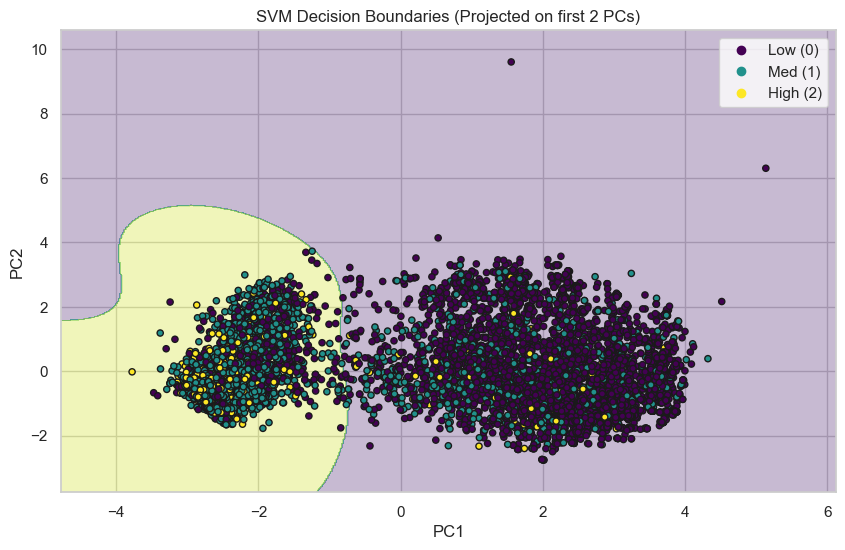

In [5]:
# --- Visualize Decision Boundaries (2D Projection) ---
# We take the first 2 PCs for visualization purposes
X_viz = X_train_pca[:, :2]
y_viz = y_train.values

# Train a visualization model on just 2 dims
viz_model = SVC(kernel=grid.best_params_['kernel'], C=grid.best_params_['C'])
viz_model.fit(X_viz, y_viz)

# Create a meshgrid
h = .02  # Step size
x_min, x_max = X_viz[:, 0].min() - 1, X_viz[:, 0].max() + 1
y_min, y_max = X_viz[:, 1].min() - 1, X_viz[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict on mesh
Z = viz_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
scatter = plt.scatter(X_viz[:, 0], X_viz[:, 1], c=y_viz, cmap='viridis', edgecolors='k', s=20)
plt.legend(handles=scatter.legend_elements()[0], labels=['Low (0)', 'Med (1)', 'High (2)'])
plt.title(f"SVM Decision Boundaries (Projected on first 2 PCs)")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 3. Generate Submission

We apply our trained, optimized SVM model to the **Test Data** (which we already transformed via PCA in Step 1) to generate the final `spend_category` predictions.

In [6]:
# --- 1. Predict on Test Data ---
# X_test_pca was already transformed in Step 1
test_predictions = best_svm.predict(X_test_pca)

# --- 2. Create Submission DataFrame ---
submission = pd.DataFrame({
    'trip_id': test['trip_id'],
    'spend_category': test_predictions
})

# Ensure Integer format
submission['spend_category'] = submission['spend_category'].astype(int)

# --- 3. Save to CSV ---
filename = "submission_supervised_svm.csv"
submission.to_csv(filename, index=False)

print(f"Saved submission: {filename}")
print(f"Shape: {submission.shape}")
submission.head()

Saved submission: submission_supervised_svm.csv
Shape: (5852, 2)


,trip_id,spend_category
0,tour_id8gzpck76,1
1,tour_idow1zxkou,0
2,tour_idue7esfqz,0
3,tour_idnj3mjzpb,0
4,tour_ida3us5yk2,0
